In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library

# Coursework 1 :
See pdf for instructions. 

In [2]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "06006553" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "ad524" # Return your short imperial login

## Helper class

In [8]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [9]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    
    # [Action required]
    # Properties set from the CID
    cid = get_CID()
    y = int(cid[-2])
    z = int(cid[-1])
    self._prob_success = 0.8 + 0.02 * (9 - y) # float
    self._gamma = 0.8 + 0.02 * y # float
    self._goal = 3 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3) z%4

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

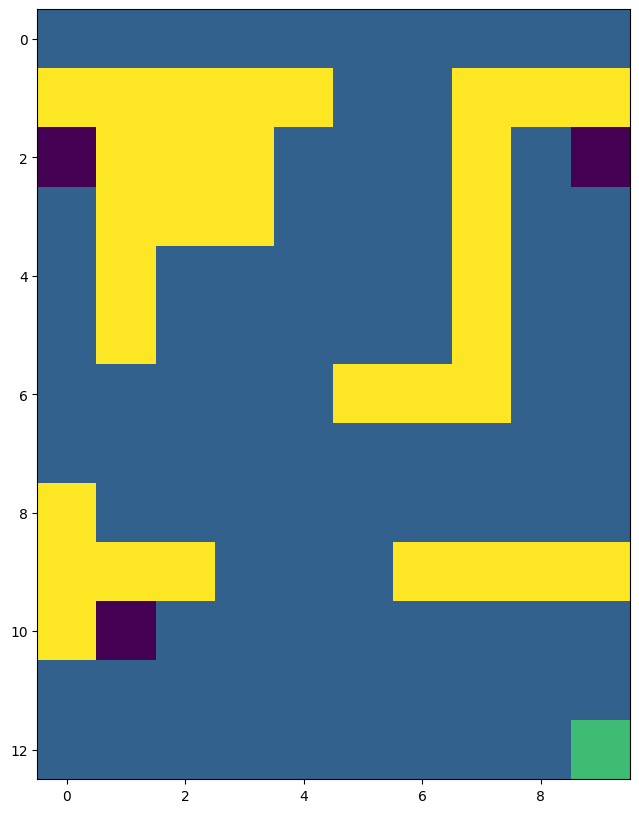

0.9


In [10]:
maze = Maze()
print(maze.get_gamma())
#print(maze.get_gamma())

## DP Agent

In [13]:
# This class define the Dynamic Programing agent 

class DP_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Dynamic Programming
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    
    # Initialisation (can be edited)
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    V = np.zeros(env.get_state_size())

    #### 
    # Add your code here
    # WARNING: for this agent only, you are allowed to access env.get_T(), env.get_R() and env.get_absorbing()
    ####


    #### Here we are accessing the environment properties ####
    # T: Transition matrix 
    # R: Reward matrix 
    # absorbing: Boolean array indicating absorbing states in the environment
    # actions: Total number of possible actions
    # states: Total number of possible states
    # gamma: Discount factor 

    T = env.get_T()
    R = env.get_R()
    absorbing = env.get_absorbing()
    actions = env.get_action_size()
    states = env.get_state_size()
    gamma = env.get_gamma()

    # Set threshold for convergence of the value function

    threshold = 1

    # Ensure gamma value is valid
    assert (gamma <=1) and (gamma >= 0), "Discount factor should be in [0, 1]."

    # Initialisation
    epochs = 0
    delta = threshold # Setting value of delta to go through the first breaking condition
    V = np.zeros(states) # Initialise values at 0 for each state

    while delta >= threshold:
      epochs += 1 # Increment the epoch
      delta = 0 # Reinitialise delta value

      # For each state
      for prior_state in range(states):

        # If not an absorbing state
        if not absorbing[0, prior_state]:
                  
          # Store the previous value for that state
          v = V[prior_state] 

          # Compute Q value
          Q = np.zeros(4) # Initialise with value 0
          for post_state in range(states):
            Q += T[prior_state, post_state,:] * (R[prior_state, post_state, :] + gamma * V[post_state])
                
          # Set the new value to the maximum of Q
          V[prior_state]= np.max(Q) 

          # Compute the new delta
          delta = max(delta, np.abs(v - V[prior_state]))
            
            
    # When the loop is finished, fill in the optimal policy
    policy = np.zeros((states, actions)) # Initialisation

    for prior_state in range(states):
      # Compute the Q value
      Q = np.zeros(4)
      for post_state in range(states):
        Q += T[prior_state, post_state,:] * (R[prior_state, post_state, :] + gamma * V[post_state])
            
      # The action that maximises the Q value gets probability 1
      policy[prior_state, np.argmax(Q)] = 1 

    return policy, V
    
   

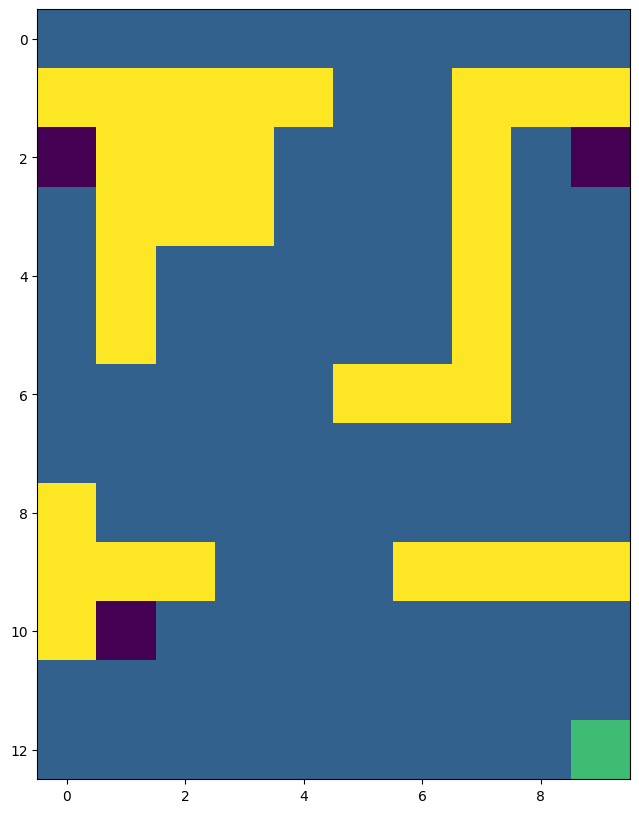

Results of the DP agent:



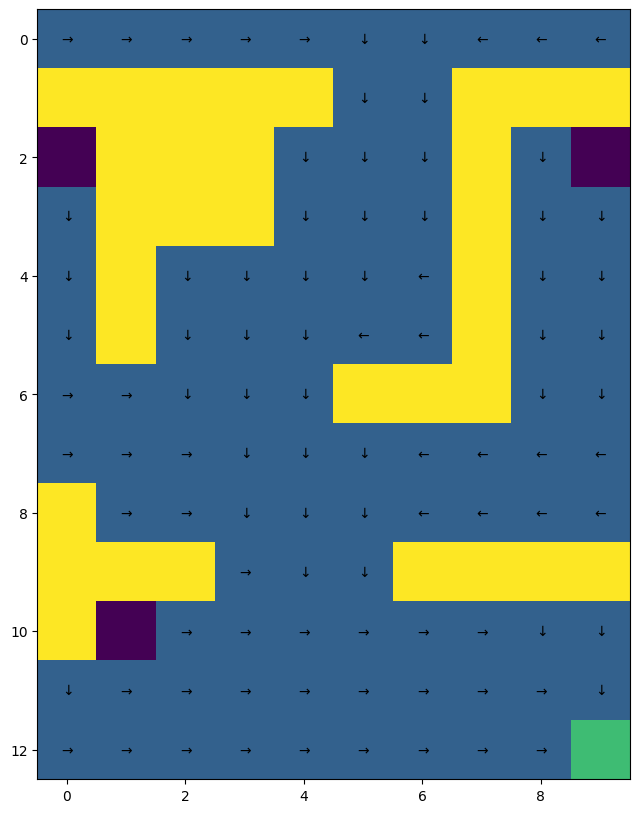

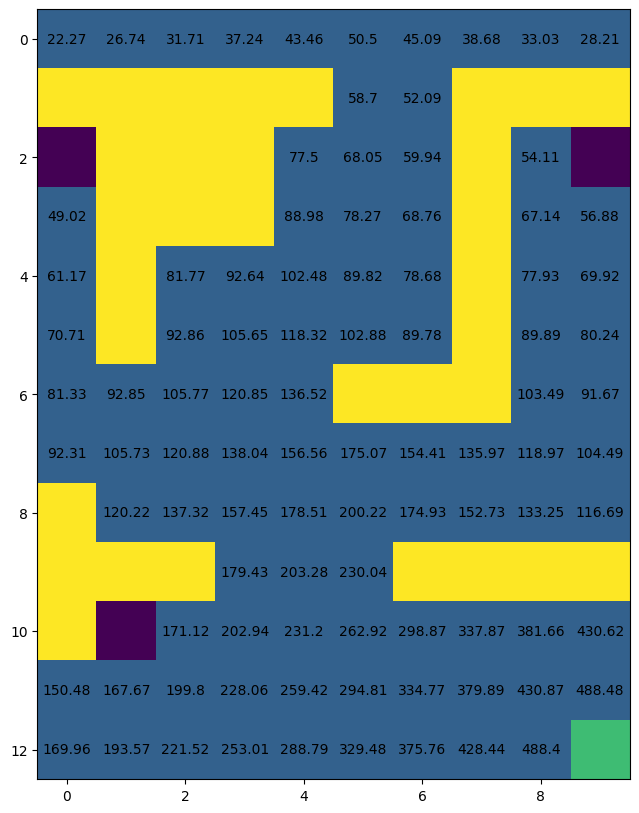

In [ ]:
# To check the implementation of DP algorithm

maze = Maze()

### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)

In [16]:
def generate_episode(env, actions, policy):
    """ To generate an episode based on the policy
    
    Args:
        env (object): The object of the maze class
        actions (int): Total number of possible actions
        policy (np.array): An array of size (number of states x number of actions)
    
    Returns:
        list: The generated episode
    """

    t, state, reward, done = env.reset() 
    episode = []
    while not done:
        action_probs = policy[state]
            
        action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
        
        t, next_state, reward, done = env.step(action)
        episode.append((t, state, action, reward))
        state = next_state

    return episode

def initialize_policy(states, actions, Q, policy, epsilon):
    """ To initialize the policy
    
    Args:
        states (int): Total number of states
        actions (int): Total number of possible actions
        Q (np.array): An array of state-action value function having size (number of states x number of actions)
        policy (np.array): An array of size (number of states x number of actions)
        epsilon (float): A parameter to choose the action based on a stochastic policy
    Returns:
        np.array: The initialized policy based on epsilon soft policy 
    """
    for state in range(states):
        best_action = random.choice(range(actions))
        for action in range(actions):
            if action == best_action:
                policy[state][action] = 1 - epsilon + (epsilon / actions)
            else:
                policy[state][action] = (epsilon / actions)  

    return policy          

## MC agent

In [ ]:
# This class define the Monte-Carlo agent

class MC_agent(object):
  
  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    epsilon=0.01
    states = env.get_state_size()
    actions = env.get_action_size()
    gamma = env.get_gamma()
    policy = np.zeros((env.get_state_size(), env.get_action_size()))
    
    # Initialize policy based on initial Q values

    policy = initialize_policy(states, actions, Q, policy, epsilon) 
    values = [V]
    total_rewards = []
    

    # env.reset() and env.step() methods of the Maze class, as well as env.get_action_size(),
    # env.get_state_size() and env.get_gamma(). 

    #### 
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####

    returns = {}

    # Set the number of episodes to run Monte Carlo algorithm
    
    
    num_episodes = 1000
    for iteration in range(num_episodes):
      
      G = 0  # Initialize return
      episode = generate_episode(env, actions, policy) # Generate an episode using the current policy
      sum_rewards = 0
      epsilon = epsilon - (epsilon/num_episodes) # Decay epsilon over time

      for i in reversed(range(0, len(episode))):   

        t, s_t, a_t, r_t = episode[i] # Time step, state, action, reward for current step
        state_action = (s_t, a_t)
        G = gamma*G + r_t # Increment total reward by reward on current timestep
        sum_rewards += r_t

        # Check if this is the first occurrence of the state-action pair in the episode

        if not state_action in [(x[1], x[2]) for x in episode[0:i]]: # to check 
        
        # Update returns for the state-action pair

          if returns.get(state_action):
            returns[state_action].append(G)
          else:
            returns[state_action] = [G]   
              
          Q[s_t][a_t] = np.mean(returns[state_action]) # Average reward across episodes
          
          Q_list = Q[s_t] 
          indices = np.where(Q_list == np.max(Q_list))[0]  # Get indices of max Q-values
          max_Q = np.random.choice(indices) 
          
          A_star = max_Q # Optimal action for the current state
          
          for a in range(actions): # Update action probability for s_t in policy
            if a == A_star:
                policy[s_t][a] = 1 - epsilon + (epsilon / actions)
            else:
                policy[s_t][a] = (epsilon / actions)
      
      # Calculate the value function V based on current policy and Q values

      V = np.sum(policy*Q, axis = 1)
      values.append(V.copy())
      total_rewards.append(sum_rewards) # Store the total rewards for the current episode
    
    return policy, values, total_rewards

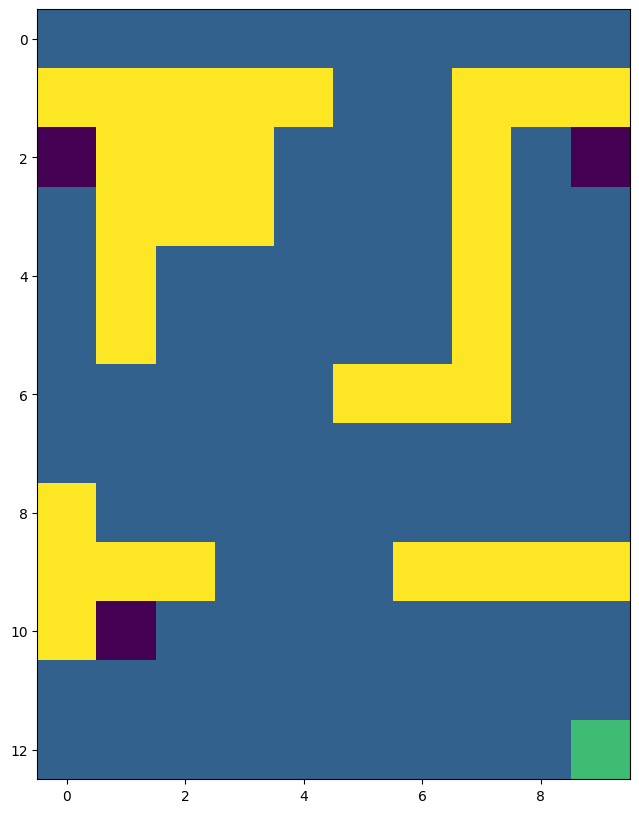

NameError: name 'returns' is not defined

In [34]:
# To check the implementation of MC algorithm

maze = Maze()
mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])

print("policy", mc_policy)
print("values", mc_values)
print("rewards", total_rewards)

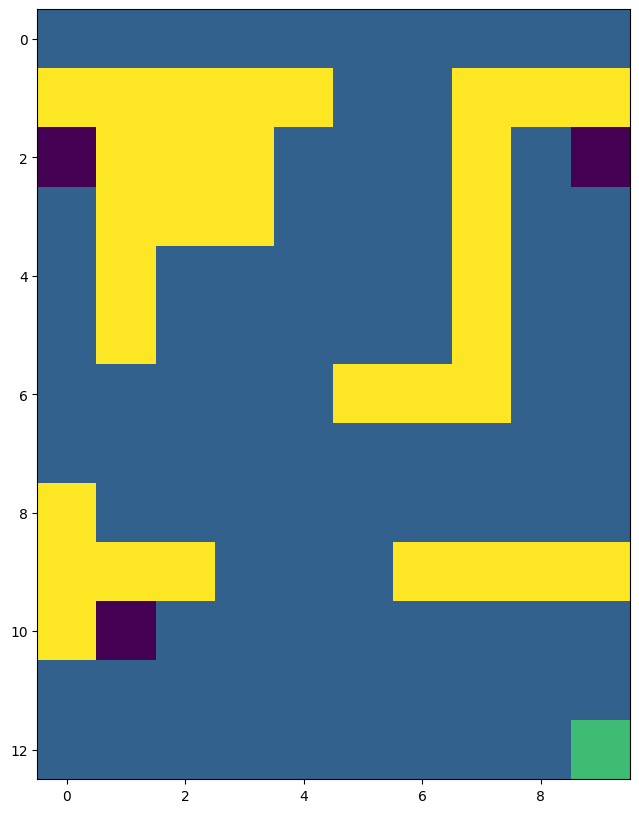

[-501.0, -501.0, -255.0, -501.0, -194.0, -501.0, -457.0, -151.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, 234.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, 131.0, -501.0, -501.0, -501.0, -501.0, -390.0, -501.0, 174.0, 37.0, -501.0, -501.0, 4.0, -501.0, -501.0, -501.0, -501.0, -501.0, -501.0, -440.0, -501.0, 175.0, -501.0, 234.0, 387.0, 294.0, 434.0, 300.0, 421.0, 403.0, 262.0, 365.0, 51.0, 432.0, 417.0, 342.0, 411.0, 424.0, 348.0, 447.0, 459.0, 455.0, 456.0, 443.0, 426.0, 408.0, 370.0, 388.0, 453.0, 464.0, 420.0, 290.0, 463.0, -109.0, 407.0, 435.0, 440.0, 429.0, 453.0, 409.0, 438.0, 323.0, 459.0, 402.0, 469.0, 387.0, 415.0, 449.0, 459.0, 461.0, -501.0, 429.0, 457.0, 462.0, 479.0, 452.0, -501.0, -501.0, 469.0, 474.0, 416.0, 451.0, 

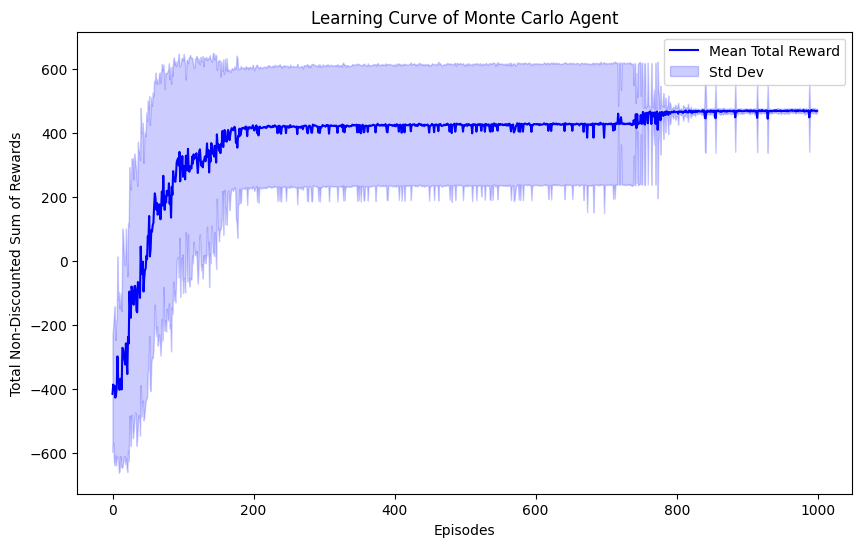

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

maze = Maze()

def run_multiple_training_runs(env, num_runs=25, num_episodes=1000):
    all_total_rewards = []
    agent = MC_agent()
    
    # Run the agent multiple times
    for run in range(num_runs):
        _, _, total_rewards = agent.solve(env)
        all_total_rewards.append(total_rewards)  # Ensure consistency in length
        print(total_rewards)
    # Convert to np.array for easier manipulation
    all_total_rewards = np.array(all_total_rewards)

    # Calculate the mean and standard deviation of rewards at each episode
    mean_rewards = np.mean(all_total_rewards, axis=0)
    std_rewards = np.std(all_total_rewards, axis=0)
    
    return mean_rewards, std_rewards

# Plotting the learning curve
def plot_learning_curve(mean_rewards, std_rewards, num_episodes=1000):
    episodes = np.arange(num_episodes)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, mean_rewards, label="Mean Total Reward", color="b")
    plt.fill_between(episodes, 
                     mean_rewards - std_rewards, 
                     mean_rewards + std_rewards, 
                     color="b", alpha=0.2, label="Std Dev")
    
    plt.xlabel("Episodes")
    plt.ylabel("Total Non-Discounted Sum of Rewards")
    plt.title("Learning Curve of Monte Carlo Agent")
    plt.legend()
    plt.show()

# Plotting the graph
mean_rewards, std_rewards = run_multiple_training_runs(maze)
plot_learning_curve(mean_rewards, std_rewards)


In [26]:
def epsilon_greedy(state, epsilon, policy, actions):
    """ To choose an random action based on greedy policy
    
    Args:
        state (int): The current state
        epsilon (float): A parameter to choose the action based on a stochastic policy
        policy (np.array): An array of size (number of states x number of actions)
        actions (int): Total number of possible actions
        
    
    Returns:
        int: The chosen action
    """

    action_probs = policy[state]      
    action = np.random.choice(np.arange(len(action_probs)), p = action_probs)   
    return action 


def initialize_policy(states, actions, Q, policy, epsilon):
    """ To choose an random action based on greedy policy
    
    Args:
        state (int): The current state
        epsilon (float): A parameter to choose the action based on a stochastic policy
        policy (np.array): An array of size (number of states x number of actions)
        actions (int): Total number of possible actions
        
    
    Returns:
        int: The chosen action
    """

    for state in range(states):
        best_action = random.choice(range(actions))
        for action in range(actions):
            if action == best_action:
                policy[state][action] = 1 - epsilon + (epsilon / actions)
            else:
                policy[state][action] = (epsilon / actions)  

    return policy          

## TD agent

In [30]:
# This class define the Temporal-Difference agent

class TD_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    values = [V]
    total_rewards = []

    #### 
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####

    # Get the absorbing states

    absorbing = env.get_absorbing()[0]

    # Set the Q-values for absorbing states to zero

    for ind, state in enumerate(absorbing):
      if state != 0:
        Q[ind, :] = 0
    
    states = env.get_state_size()
    actions = env.get_action_size()
    gamma = env.get_gamma()   

    alpha = 0.1 # 0.1  Although theory says that alpha should follow Robbins-Monro conditions, but in practice it is observed that the SARSA stil converges by using constant aplha - David Silver
    epsilon = 0.4  # 0.4

    n_episodes = 1000 # Total number of episodes to run

    # Initialize the policy based on the initial Q-values

    policy = initialize_policy(states, actions, Q, policy, epsilon)

    for episode in range(n_episodes):
      
      epsilon = epsilon - (epsilon/n_episodes) # Implementation of epsilon decay
      t, state, reward, done = env.reset()
      action = epsilon_greedy(state, epsilon, policy, actions) # Select the first action using epsilon-greedy policy
      reward_sum = 0 # Track the sum of rewards for this episode
      
      # Loop over each step within the episode until the agent reaches a terminal state

      while not done:

        # Take action and observe the next state, reward, and whether the episode is done

        t, next_state, reward, done = env.step(action)

        alpha = 1 / (t + 1) # Implement alpha decay

        next_action = epsilon_greedy(next_state, epsilon, policy, actions) # Select the next action using epsilon-greedy policy

        # Update the Q-value using the SARSA update rule

        Q[state, action] += alpha * (
           reward + gamma * Q[next_state, next_action] - Q[state, action]
        )      

        # Update policy to choose the action with the highest Q-value for the current state

        Q_list = Q[state] 
        indices = np.where(Q_list == np.max(Q_list))[0]  # Get indices of max Q-values
        max_Q = np.random.choice(indices) 
        A_star = max_Q # choose the best action

        for a in range(actions): # Update action probability for s_t in policy
          if a == A_star:
              policy[state][a] = 1 - epsilon + (epsilon / actions)
          else:
              policy[state][a] = (epsilon / actions)

         # Move to the next state and action
         
        state = next_state
        action = next_action
        reward_sum += reward

      total_rewards.append(reward_sum)       

      # Calculate the value function V based on current policy and Q values

      V = np.sum(policy*Q, axis = 1)
      values.append(V.copy())
      
    return policy, values, total_rewards

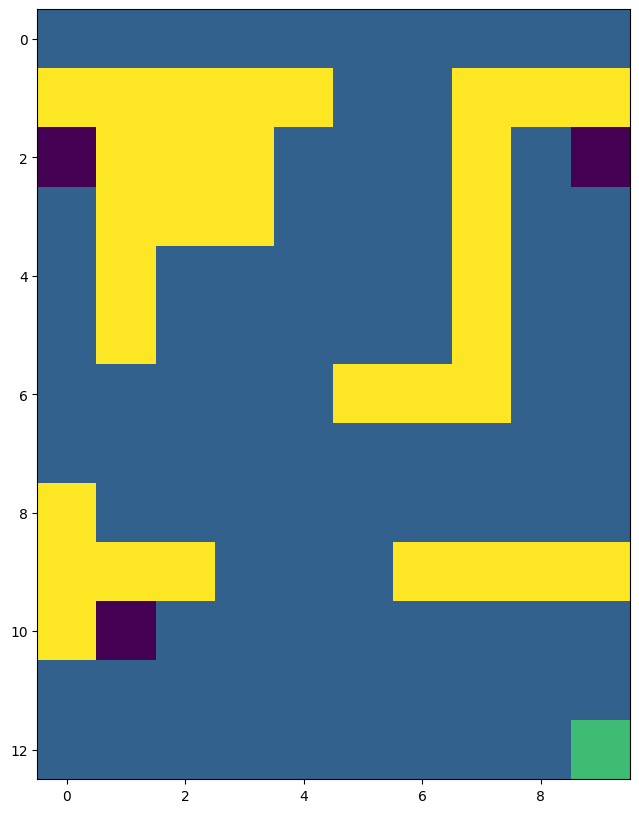

Results of the TD agent:



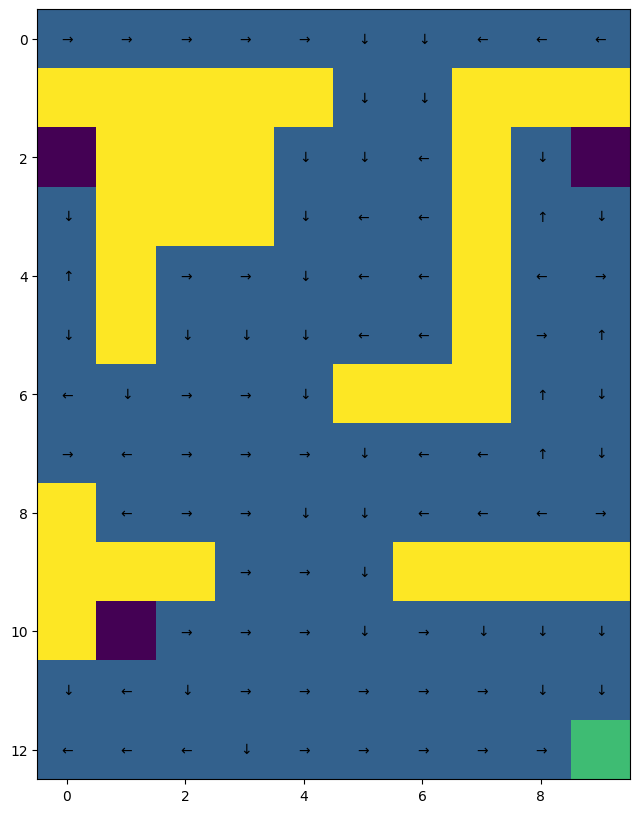

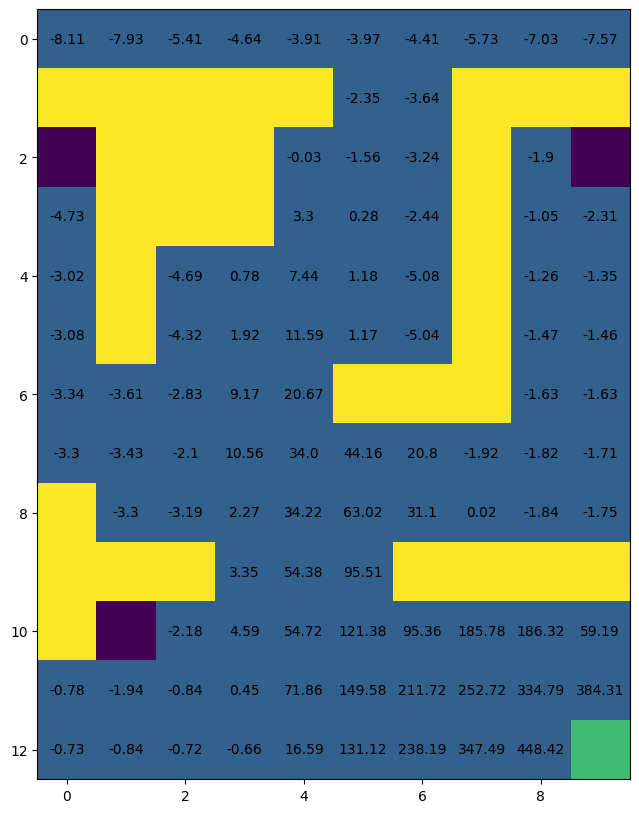

policy [[0.03736289 0.88791134 0.03736289 0.03736289]
 [0.03684319 0.88947042 0.03684319 0.03684319]
 [0.03684319 0.88947042 0.03684319 0.03684319]
 [0.03676954 0.88969137 0.03676954 0.03676954]
 [0.03676954 0.88969137 0.03676954 0.03676954]
 [0.03676954 0.03676954 0.88969137 0.03676954]
 [0.03680635 0.03680635 0.88958095 0.03680635]
 [0.03713927 0.03713927 0.03713927 0.88858219]
 [0.03713927 0.03713927 0.03713927 0.88858219]
 [0.03713927 0.03713927 0.03713927 0.88858219]
 [0.03676954 0.03676954 0.88969137 0.03676954]
 [0.03680635 0.03680635 0.88958095 0.03680635]
 [0.1        0.7        0.1        0.1       ]
 [0.03684319 0.03684319 0.88947042 0.03684319]
 [0.03676954 0.03676954 0.88969137 0.03676954]
 [0.03680635 0.03680635 0.03680635 0.88958095]
 [0.04949237 0.04949237 0.8515229  0.04949237]
 [0.1        0.7        0.1        0.1       ]
 [0.04491491 0.04491491 0.86525526 0.04491491]
 [0.03676954 0.03676954 0.88969137 0.03676954]
 [0.03676954 0.03676954 0.03676954 0.88969137]
 [0.03

In [ ]:
# Implementation of TD algorithm

maze = Maze()
td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

print("policy", td_policy)
print("values", td_values)
print("rewards", total_rewards)


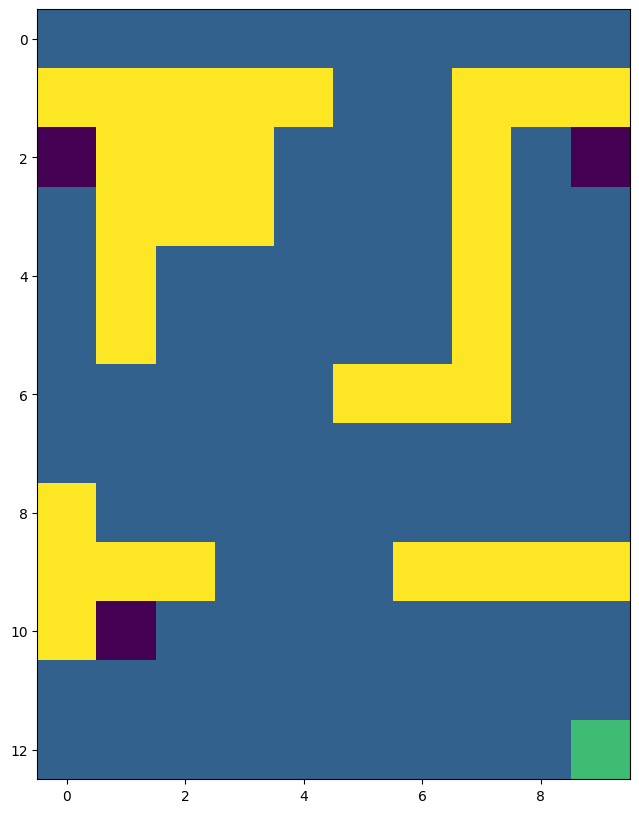

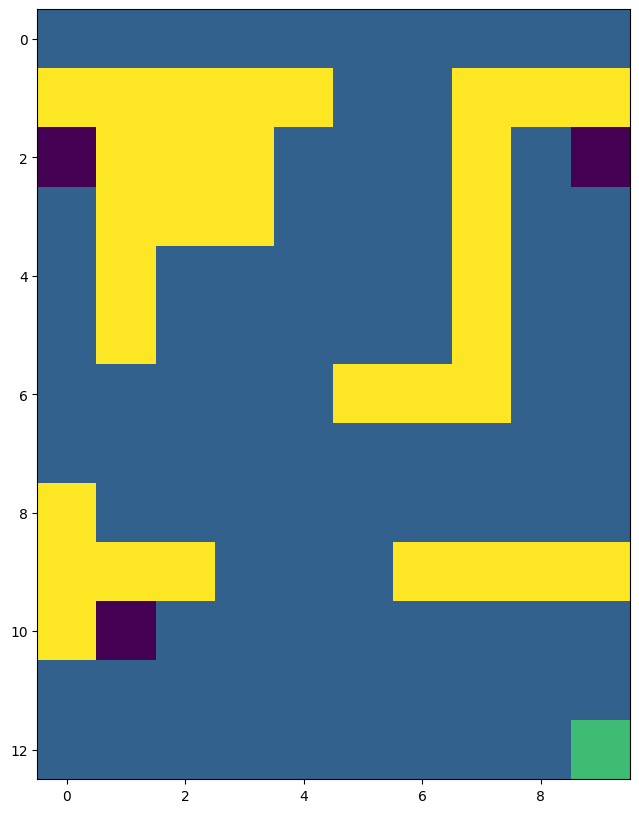

[-501.0, -254.0, -194.0, -322.0, -290.0, -443.0, 172.0, -251.0, -286.0, -198.0, -343.0, -225.0, -157.0, -173.0, -501.0, -408.0, -131.0, -501.0, -508.0, -207.0, -329.0, 241.0, -99.0, -501.0, -239.0, -221.0, -264.0, -501.0, -501.0, -501.0, -275.0, 302.0, -180.0, -159.0, 304.0, 207.0, -108.0, -346.0, -221.0, -142.0, 172.0, -171.0, 44.0, -431.0, 65.0, -161.0, -210.0, -418.0, -363.0, -137.0, 289.0, 360.0, -135.0, 181.0, -200.0, -465.0, -134.0, -217.0, 276.0, 224.0, 176.0, -148.0, 363.0, 387.0, -293.0, -219.0, 290.0, 107.0, -106.0, 349.0, 190.0, 186.0, 310.0, 328.0, 408.0, 386.0, 167.0, -137.0, 283.0, 126.0, 145.0, 256.0, 271.0, 330.0, 247.0, -156.0, -280.0, -191.0, 311.0, 403.0, 435.0, 378.0, -213.0, -263.0, 397.0, 451.0, -536.0, 298.0, -227.0, -219.0, -216.0, 316.0, -107.0, 203.0, 348.0, -181.0, 267.0, 357.0, -215.0, -343.0, 430.0, -143.0, -193.0, -384.0, 375.0, -154.0, 350.0, -348.0, -123.0, 428.0, -235.0, -180.0, 391.0, 402.0, -296.0, -162.0, 397.0, -315.0, -208.0, 300.0, 293.0, -290.0, 

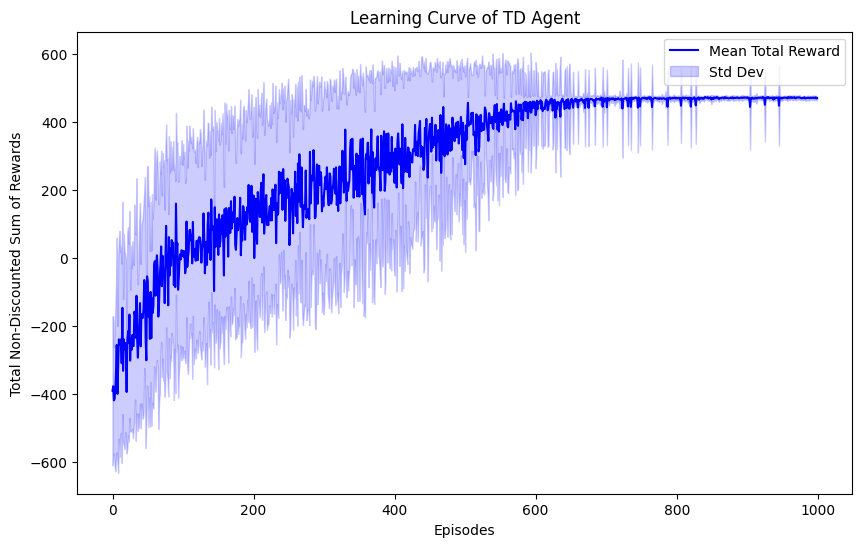

In [32]:
import numpy as np
import matplotlib.pyplot as plt

maze = Maze()
maze = Maze()
td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

def run_multiple_training_runs(env, num_runs=25, num_episodes=1000):
    all_total_rewards = []
    agent = TD_agent()
    
    # Run the agent multiple times
    for run in range(num_runs):
        _, _, total_rewards = agent.solve(env)
        all_total_rewards.append(total_rewards)  # Ensure consistency in length
        print(total_rewards)
    # Convert to np.array for easier manipulation
    all_total_rewards = np.array(all_total_rewards)

    # Calculate the mean and standard deviation of rewards at each episode
    mean_rewards = np.mean(all_total_rewards, axis=0)
    std_rewards = np.std(all_total_rewards, axis=0)
    
    return mean_rewards, std_rewards

# Plotting the learning curve
def plot_learning_curve(mean_rewards, std_rewards, num_episodes=1000):
    episodes = np.arange(num_episodes)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, mean_rewards, label="Mean Total Reward", color="b")
    plt.fill_between(episodes, 
                     mean_rewards - std_rewards, 
                     mean_rewards + std_rewards, 
                     color="b", alpha=0.2, label="Std Dev")
    
    plt.xlabel("Episodes")
    plt.ylabel("Total Non-Discounted Sum of Rewards")
    plt.title("Learning Curve of TD Agent")
    plt.legend()
    plt.show()

# Plotting the graph
mean_rewards, std_rewards = run_multiple_training_runs(maze)
plot_learning_curve(mean_rewards, std_rewards)


## Example main

Creating the Maze:



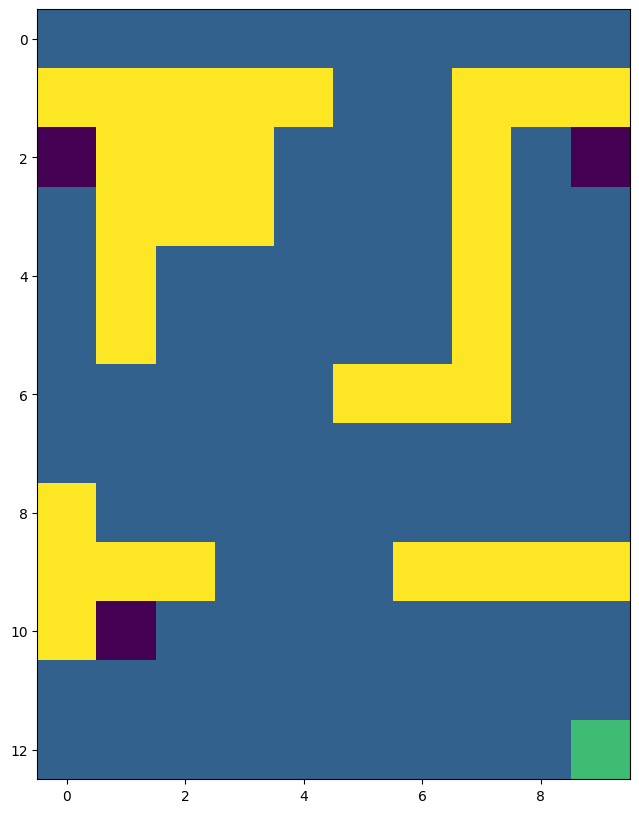

T [[[0.96 0.12 0.96 0.96]
  [0.04 0.88 0.04 0.04]
  [0.   0.   0.   0.  ]
  ...
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]

 [[0.04 0.04 0.04 0.88]
  [0.92 0.08 0.92 0.08]
  [0.04 0.88 0.04 0.04]
  ...
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]

 [[0.   0.   0.   0.  ]
  [0.04 0.04 0.04 0.88]
  [0.92 0.08 0.92 0.08]
  ...
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]

 ...

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  ...
  [0.04 0.04 0.88 0.04]
  [0.04 0.88 0.04 0.04]
  [0.   0.   0.   0.  ]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  ...
  [0.04 0.04 0.04 0.88]
  [0.04 0.04 0.88 0.04]
  [0.04 0.88 0.04 0.04]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  ...
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]]
T_shape (98, 98, 4)
R [[[ -1.  -1.  -1.  -1.]
  [ -1.  -1.  -1.  -1.]
  [ -1.  -

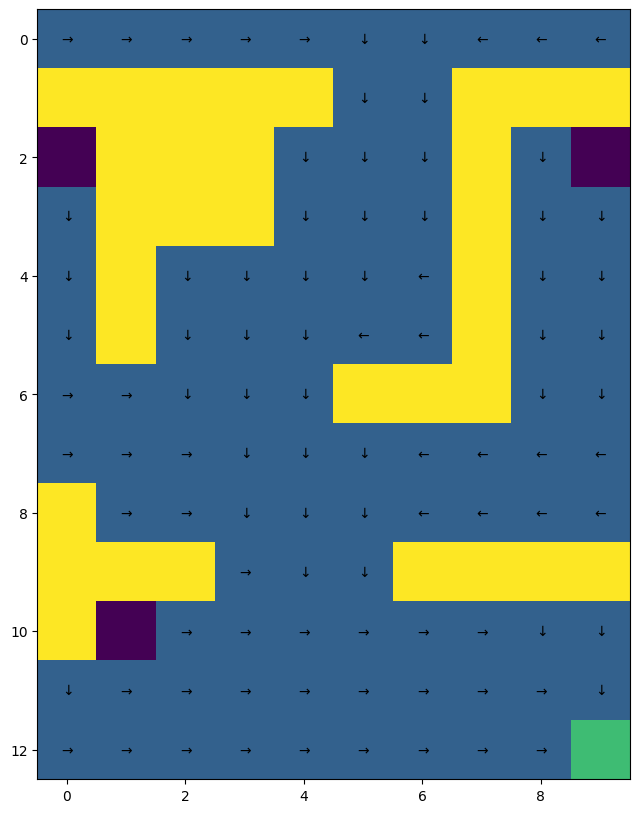

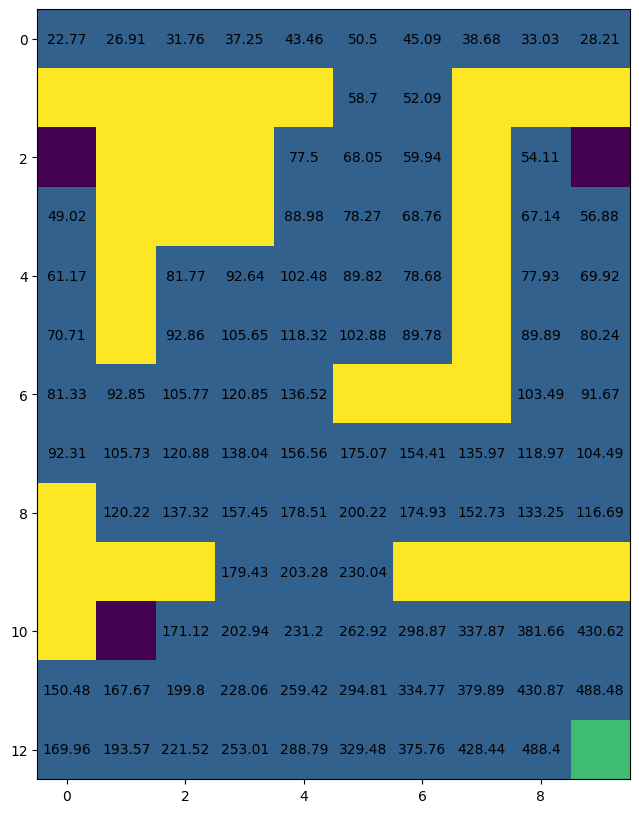

Results of the MC agent:



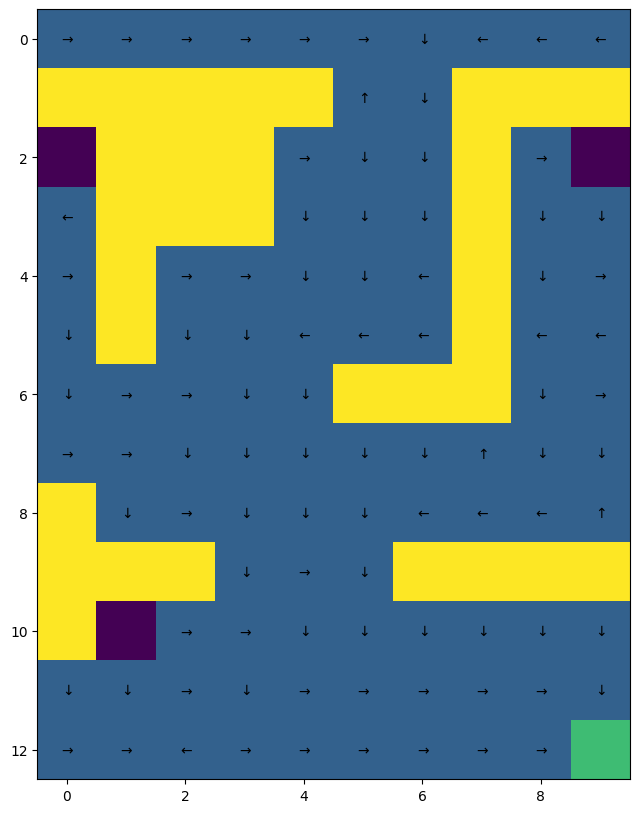

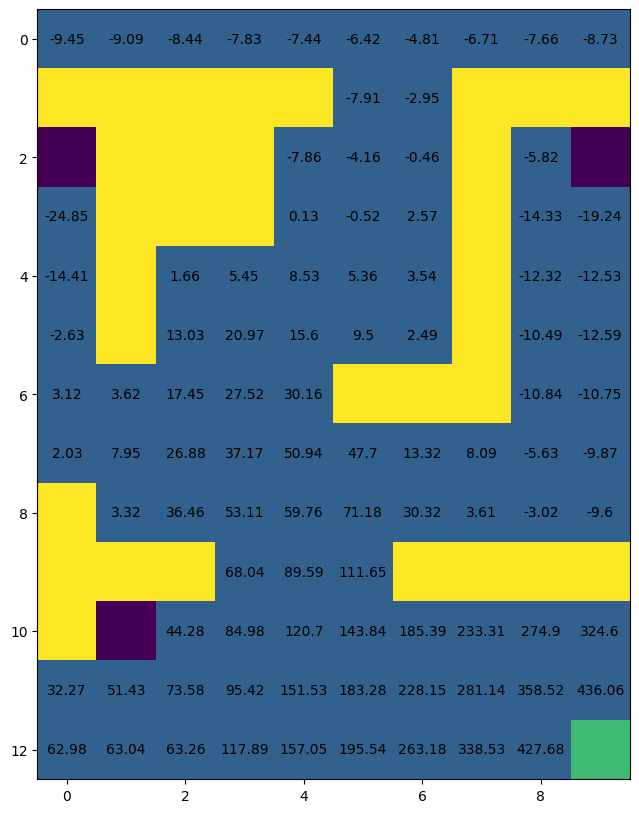

Results of the TD agent:



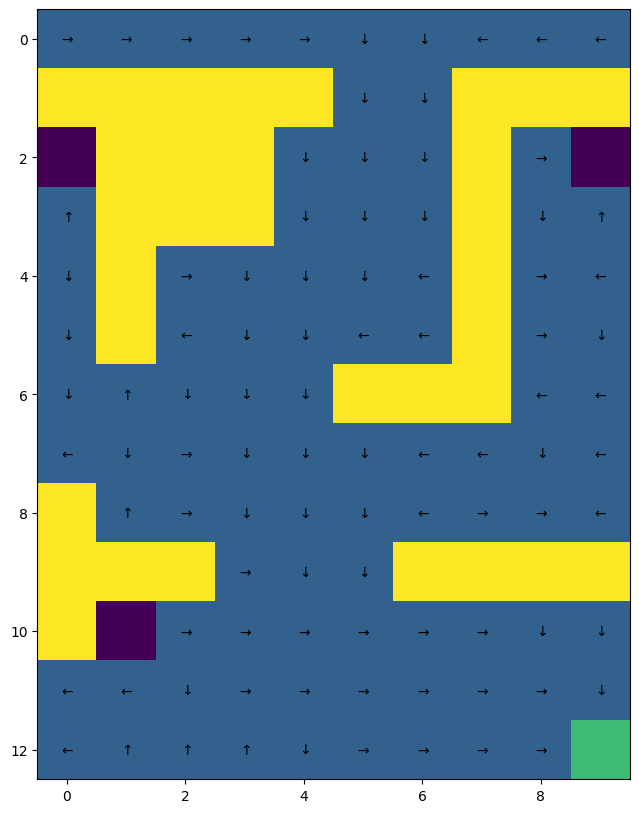

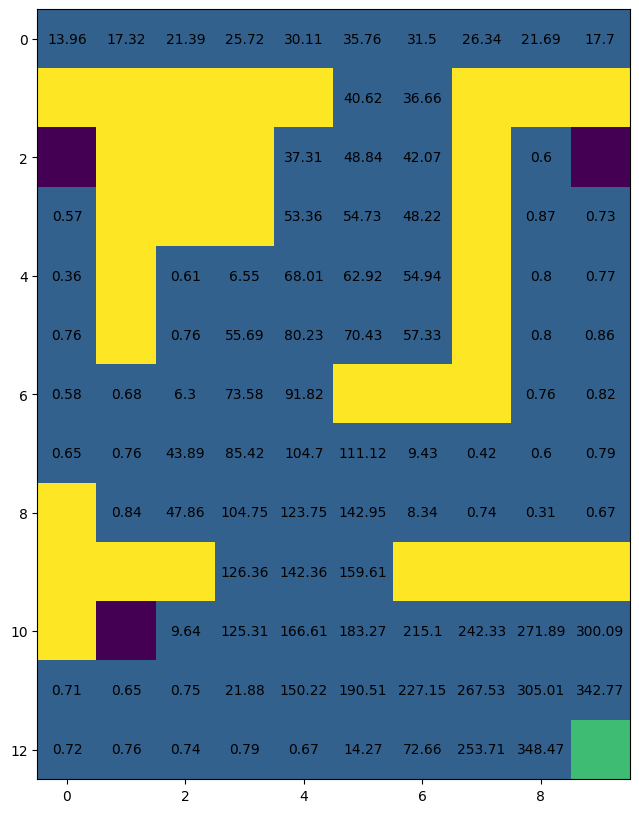

In [17]:
# Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


### Question 2: Monte-Carlo learning

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])


### Question 3: Temporal-Difference learning

td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])